In [1]:
using Printf

######################################################################################################
### The key observations here are the following.  The small obervations are here:
### a) The only way we can reach the target planet in 1 step is if a teleporter is equidistant from
###    the starter planet and the current planet.
### b) If we only have one teleporter and we can't reach the planet in one hop, then we can't reach
###    the planet in infinite hops, because we are stuck on the surface of the L1-sphere around
###    the only teleporter, and the planet isn't on the surface of that sphere.
### c) If we can't reach the planet in one hop, the set of possible positions is the union of L1-spheres
###    each of which is centered around a teleporter.  Note these L1-spheres have a radius of the
###    distance of the starting planet to the teleporter.  Furthermore, since the starting planet
###    is in EACH of these spheres, the entire network is CONNECTED.
### d) Now, consider a second hop using teleporter i.  We consider the CONNECTED set of possible
###    starting positions before this 2nd hop, and we realize that this connected set has a minimum
###    distance from teleporter i and a maximum distance from teleporter i.  Since that graph is
###    connected and since the distance function is continuous, it is possible to hop to any distance
###    from teleporter i between these two extreme.  Thus, the set of points where I can get using
###    teleporter i is the space between the surfaces of 2 concentric L-1 spheres centered at teleporter
###    i.
### e) This sets up a sort of dynamic programming approach.  We can calculate the next set of inner-outer
###    radii based on the previous set.  We notice that the outer radii will all increase at each step, and
###    the inner radii will decrease, so we will eventually hit the target planet.
###
###    --- Outer radii can be calculated as Ui = max_j{U_j + D_i,j}
###    --- Inner radii can be calculated as Li = min_J{ L_j > D_j ? L_j - D_j : U_j < D_j ? D_j - U_j : 0}
### f) The worst case here is when U_i == U_j and D_i,j = 1.  Then U_i and U_j will grow by 1 each step
###    so it will take 2000 steps to get from one end of the space to the other, so this is O(N^2*M)
###
### Now for the observations we need for the large.  In short, the biggest problem is that "M" factor.
### Note I didn't come up with most of this -- this is a summary of the given solution.
### g) Let's assume that we check for a 1 step solution beforehand.  Thus, we can assume we need to
###    take at least two steps.
### h) Now lets assume we have two teleporters, where one (say teleporter "u") is closer to the
###    starting planet (P), and one (say teleporter "v') is closer to the target planet (Q).  We claim
###    that when this is the case, we can always make it to the target planet in exactly 2 moves
###    by first using teleporter v and then using teleporter u.
###    --- To see this, we draw the L1-sphere around v that includes P.  This is where we can reach
###        on our first jump.
###    --- We also draw the L1 sphere around u that includes Q.  This represents the set of points from
###        which we can reach get to Q on the next jump.
###    --- We observe these two spheres intersect (technicals of the distance arguments omitted),
###        so there is an intermediate point we can use for the first hop.
### i) The previous observations suggests that there is a symmetry/reversability to the problem.  So we can
###    swap P and Q as needed such that all of the teleporters are closest to P.
### j) As per our discussion above in the short, U_i increases with steps, and L_i decreases with steps,
###    so after taking care of cases in (g) and (h) and perhaps switching the role so P/Q in (i), we
###    can assume that we are never limited by L_i (as Q isn't in the initial L_is, and the L_is shrink).
###    Thus, we only really have to worry about the U_is.
### k) Now we consider how the Ui terms grow.  The key observation is that if I start a path at i with Ui
###    and take several hops and end  at j, the "new Uj" is just the original Ui + the sum of the distances
###    of the hops I took.
### l) While we can't easily make an efficient dp for the "max possible" Ui, we can make a DP that calculates
###    the "longest path" from i to j in N hops.  The recursion that works is as follows
###    D[i,j,2^k] = max_x{D[i,x,2^(k-1)]+D[x,j,2^(k-1)]}.  We of course store the exponents (or 1+exponent
###    in the case of julia) as the 3rd index, but the recursion lets us get a set max distances for
###    binary hops in log(M)*N^3 time.
### m) After this, we just do a binary search on the number of hops which are needed
######################################################################################################

function main(infn="")
    infile = (infn != "") ? open(infn,"r") : length(ARGS) > 0 ? open(ARGS[1],"r") : stdin
    tt = parse(Int64,readline(infile))
    for qq in 1:tt
        print("Case #$qq: ")
        N = parse(Int64,rstrip(readline(infile)))
        Xs,Ys,Zs = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        Xf,Yf,Zf = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        X,Y,Z = fill(0,N),fill(0,N),fill(0,N)
        for i in 1:N
            X[i],Y[i],Z[i] = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        end

        Darr = fill(0,N,N)
        Ds = fill(0,N)
        Df = fill(0,N)
        for i in 1:N
            for j in i+1:N
                Darr[i,j] = Darr[j,i] = abs(X[j]-X[i]) + abs(Y[j]-Y[i]) + abs(Z[j]-Z[i])
            end
            Ds[i] = abs(Xs-X[i]) + abs(Ys-Y[i]) + abs(Zs-Z[i])
            Df[i] = abs(Xf-X[i]) + abs(Yf-Y[i]) + abs(Zf-Z[i])
        end

        ## Do the first
        first = false
        closerToF = false
        closerToS = false
        for i in 1:N
            if Ds[i] == Df[i]; first=true; break;
            elseif Ds[i] < Df[i]; closerToS=true;
            else;                 closerToF=true;
            end 
        end
        if first; print("1\n"); continue; end
        if N==1; print("IMPOSSIBLE\n"); continue; end 
        if closerToF && closerToS; print("2\n"); continue; end
        if closerToF; (Ds,Df) = (Df,Ds); end

        ## Build the longest distance matrix
        ## There will be some overflow, but we can walk our way up
        ## to what we need and then walk our way back down.
        ## the overflow will only happen

        Dtarg = fill(typemax(Int128),N,N)
        for j in 1:N
            targ = Int128(Df[j])
            for i in 1:N
                Dtarg[i,j] = targ-Int128(Ds[i])
            end
        end

        D = fill(zero(Int128),N,N,42)
        for i in 1:N
            for j in 1:N
                D[i,j,1] = Int128(Darr[i,j])
            end
        end

        k = 1
        while !any([D[i,j,k] >= Dtarg[i,j] for i in 1:N for j in 1:N])
            k += 1
            for i in 1:N
                for j in 1:N
                    D[i,j,k] = Int128(D[i,j,k-1])
                    for x in 1:N
                        D[i,j,k] = max(D[i,j,k],D[i,x,k-1]+D[x,j,k-1])
                    end
                end
            end
        end
        if k==1; print("2\n"); continue; end
        if k==2; print("3\n"); continue; end
        Dub = [D[i,j,k] for i in 1:N, j in 1:N]
        Dlb = [D[i,j,k-1] for i in 1:N, j in 1:N]
        Dtest = fill(zero(Int128),N,N)
        ub = 2^(k-1)
        lb = 2^(k-2)
        for xidx in k-2:-1:1
            m = (ub+lb) ÷ 2
            for i in 1:N
                for j in 1:N
                    Dtest[i,j] = Dlb[i,j]
                    for x in 1:N
                        Dtest[i,j] = max(Dtest[i,j],Dlb[i,x]+D[x,j,xidx])
                    end
                end
            end
            if any(Dtest .≥ Dtarg)
                Dub[:,:] = Dtest
                ub = m
            else
                Dlb[:,:] = Dtest
                lb = m
            end
        end
        print("$(ub+1)\n")
    end
end

main (generic function with 2 methods)

In [2]:
using Profile, ProfileSVG, ProfileVega

Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #4: 2190
Case #5: 57
Case #6: 14
Case #7: 2061
Case #8: 15
Case #9: 12
Case #10: 74
Case #11: 84
Case #12: 60
Case #13: 110
Case #14: 5
Case #15: 2
Case #16: 95
Case #17: 27
Case #18: 6
Case #19: 39
Case #20: 2
Case #21: 9
Case #22: 150
Case #23: 5997
Case #24: 15
Case #25: 60
Case #26: 47
Case #27: 193
Case #28: 2
Case #29: 187
Case #30: 2632
Case #31: 19
Case #32: 2318
Case #33: 2297
Case #34: 25
Case #35: 222
Case #36: 2105
Case #37: 18
Case #38: 40
Case #39: 1883
Case #40: 10
Case #41: 6
Case #42: 50
Case #43: 2334
Case #44: 30
Case #45: 139
Case #46: 105
Case #47: 10
Case #48: 5997
Case #49: 31
Case #50: 5
Case #51: 1997
Case #52: 89
Case #53: 1999
Case #54: 34
Case #55: 33
Case #56: 23
Case #57: 2734
Case #58: 19
Case #59: 84
Case #60: 44
Case #61: 38
Case #62: 29
Case #63: 29
Case #64: 58
Case #65: 21
Case #66: 33
Case #67: 16
Case #68: 7
Case #69: 47
Case #70: 133
Case #71: 21
Case #72: 39


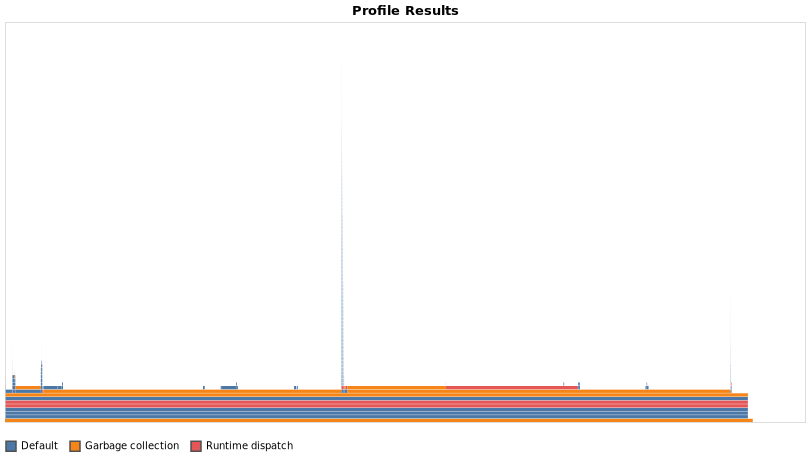

In [3]:
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in")
Profile.clear()
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in2")
ProfileVega.view()

In [12]:
using Random
Random.seed!(2345)
a = [rand(Int128) for i in 1:1000, j in 1:1000]
b = [rand(Int128) for i in 1:1000, j in 1:1000]

1000×1000 Array{Int128,2}:
   81630828661294153057417077563963151222  …   -42148280915756330593807094156959574679
 -106774194634819756276041601532816724282         570926001398974663431960115637505887
   17597629935558713418512300794258502933      165327507680893813980329052236164743756
   -5260370593288736065300634142353902326     -119536801339737139189771106632407168267
 -120034837040797170738940330635648340419     -135663395886279237408472912434134057729
  -55482836285359542455047044803961172072  …   143004415529142655441836592458976085912
   -1788278338428594088357017099230135250      -15677921746771976551200586264187898958
  116981808645526999375841565146950053920      149851889516531043082740166890295976969
   15362620034379191776709285394172557187      -39665946095480818643294405298575931181
   -4840015568270778870761466099252687913       69477434273357674454718829598997175113
  104472919965932757481754478662889738884  …   -65970441492899539520322036592618584364
  -4872378796191

In [16]:
function set1(a::Array{Int128,2},b::Array{Int128,2})
    for i in 1:1000
        for j in 1:1000
            b[i,j] = a[i,j]
        end
    end
end

function set2(a::Array{Int128,2},b::Array{Int128,2})
    b[:,:] = a
end

function set1b(a::Array{Int128,2},b::Array{Int128,2})
    for i in 1:10
        set1(a,b)
        set1(b,a)
    end
end

function set2b(a::Array{Int128,2},b::Array{Int128,2})
    for i in 1:10
        set2(a,b)
        set2(b,a)
    end
end

set2b (generic function with 1 method)

In [21]:
@time begin
    set1b(a,b)
end

  0.179120 seconds


In [22]:
@time begin
    set2b(a,b)
end

  0.050724 seconds


In [23]:
a = [1,2,3,4]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [24]:
repeat(a,1,4)

4×4 Array{Int64,2}:
 1  1  1  1
 2  2  2  2
 3  3  3  3
 4  4  4  4

In [25]:
repeat(a',4,1)

4×4 Array{Int64,2}:
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4

In [32]:
b = repeat(a,1,4) .- repeat(a',4,1)

4×4 Array{Int64,2}:
 0  -1  -2  -3
 1   0  -1  -2
 2   1   0  -1
 3   2   1   0

In [33]:
repeat(b[:,2],1,4)

4×4 Array{Int64,2}:
 -1  -1  -1  -1
  0   0   0   0
  1   1   1   1
  2   2   2   2

In [34]:
using Printf

######################################################################################################
### The key observations here are the following.  The small obervations are here:
### a) The only way we can reach the target planet in 1 step is if a teleporter is equidistant from
###    the starter planet and the current planet.
### b) If we only have one teleporter and we can't reach the planet in one hop, then we can't reach
###    the planet in infinite hops, because we are stuck on the surface of the L1-sphere around
###    the only teleporter, and the planet isn't on the surface of that sphere.
### c) If we can't reach the planet in one hop, the set of possible positions is the union of L1-spheres
###    each of which is centered around a teleporter.  Note these L1-spheres have a radius of the
###    distance of the starting planet to the teleporter.  Furthermore, since the starting planet
###    is in EACH of these spheres, the entire network is CONNECTED.
### d) Now, consider a second hop using teleporter i.  We consider the CONNECTED set of possible
###    starting positions before this 2nd hop, and we realize that this connected set has a minimum
###    distance from teleporter i and a maximum distance from teleporter i.  Since that graph is
###    connected and since the distance function is continuous, it is possible to hop to any distance
###    from teleporter i between these two extreme.  Thus, the set of points where I can get using
###    teleporter i is the space between the surfaces of 2 concentric L-1 spheres centered at teleporter
###    i.
### e) This sets up a sort of dynamic programming approach.  We can calculate the next set of inner-outer
###    radii based on the previous set.  We notice that the outer radii will all increase at each step, and
###    the inner radii will decrease, so we will eventually hit the target planet.
###
###    --- Outer radii can be calculated as Ui = max_j{U_j + D_i,j}
###    --- Inner radii can be calculated as Li = min_J{ L_j > D_j ? L_j - D_j : U_j < D_j ? D_j - U_j : 0}
### f) The worst case here is when U_i == U_j and D_i,j = 1.  Then U_i and U_j will grow by 1 each step
###    so it will take 2000 steps to get from one end of the space to the other, so this is O(N^2*M)
###
### Now for the observations we need for the large.  In short, the biggest problem is that "M" factor.
### Note I didn't come up with most of this -- this is a summary of the given solution.
### g) Let's assume that we check for a 1 step solution beforehand.  Thus, we can assume we need to
###    take at least two steps.
### h) Now lets assume we have two teleporters, where one (say teleporter "u") is closer to the
###    starting planet (P), and one (say teleporter "v') is closer to the target planet (Q).  We claim
###    that when this is the case, we can always make it to the target planet in exactly 2 moves
###    by first using teleporter v and then using teleporter u.
###    --- To see this, we draw the L1-sphere around v that includes P.  This is where we can reach
###        on our first jump.
###    --- We also draw the L1 sphere around u that includes Q.  This represents the set of points from
###        which we can reach get to Q on the next jump.
###    --- We observe these two spheres intersect (technicals of the distance arguments omitted),
###        so there is an intermediate point we can use for the first hop.
### i) The previous observations suggests that there is a symmetry/reversability to the problem.  So we can
###    swap P and Q as needed such that all of the teleporters are closest to P.
### j) As per our discussion above in the short, U_i increases with steps, and L_i decreases with steps,
###    so after taking care of cases in (g) and (h) and perhaps switching the role so P/Q in (i), we
###    can assume that we are never limited by L_i (as Q isn't in the initial L_is, and the L_is shrink).
###    Thus, we only really have to worry about the U_is.
### k) Now we consider how the Ui terms grow.  The key observation is that if I start a path at i with Ui
###    and take several hops and end  at j, the "new Uj" is just the original Ui + the sum of the distances
###    of the hops I took.
### l) While we can't easily make an efficient dp for the "max possible" Ui, we can make a DP that calculates
###    the "longest path" from i to j in N hops.  The recursion that works is as follows
###    D[i,j,2^k] = max_x{D[i,x,2^(k-1)]+D[x,j,2^(k-1)]}.  We of course store the exponents (or 1+exponent
###    in the case of julia) as the 3rd index, but the recursion lets us get a set max distances for
###    binary hops in log(M)*N^3 time.
### m) After this, we just do a binary search on the number of hops which are needed
######################################################################################################

function main(infn="")
    infile = (infn != "") ? open(infn,"r") : length(ARGS) > 0 ? open(ARGS[1],"r") : stdin
    tt = parse(Int64,readline(infile))
    for qq in 1:tt
        print("Case #$qq: ")
        N = parse(Int64,rstrip(readline(infile)))
        Xs,Ys,Zs = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        Xf,Yf,Zf = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        X,Y,Z = fill(0,N),fill(0,N),fill(0,N)
        for i in 1:N
            X[i],Y[i],Z[i] = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        end

        Darr = fill(0,N,N)
        Ds = fill(0,N)
        Df = fill(0,N)
        for i in 1:N
            for j in i+1:N
                Darr[i,j] = Darr[j,i] = abs(X[j]-X[i]) + abs(Y[j]-Y[i]) + abs(Z[j]-Z[i])
            end
            Ds[i] = abs(Xs-X[i]) + abs(Ys-Y[i]) + abs(Zs-Z[i])
            Df[i] = abs(Xf-X[i]) + abs(Yf-Y[i]) + abs(Zf-Z[i])
        end

        ## Do the first
        first = false
        closerToF = false
        closerToS = false
        for i in 1:N
            if Ds[i] == Df[i]; first=true; break;
            elseif Ds[i] < Df[i]; closerToS=true;
            else;                 closerToF=true;
            end 
        end
        if first; print("1\n"); continue; end
        if N==1; print("IMPOSSIBLE\n"); continue; end 
        if closerToF && closerToS; print("2\n"); continue; end
        if closerToF; (Ds,Df) = (Df,Ds); end

        ## Build the longest distance matrix
        ## There will be some overflow, but we can walk our way up
        ## to what we need and then walk our way back down.
        ## the overflow will only happen

        Dtarg = repeat(Df',N,1) .- repeat(Ds,1,N)
        D = Vector{Array{Int128,2}}()
        D1 = Int128.(Darr)
        push!(D,D1)

        k = 1
        Dtry = fill(zero(Int128),N,N)
        while !any(D[end] .>= Dtarg)
            k += 1
            Dnew = fill(zero(Int128),N,N)
            for x in 1:N
                Dtry .= repeat(D[end][:,x],1,N) .+ repeat(D[end][x,:]',N,1)
                Dnew .= max.(Dnew,Dtry)
            end
            push!(D,Dnew)
        end

        if k==1; print("2\n"); continue; end
        if k==2; print("3\n"); continue; end
        Dub = copy(D[end])
        Dlb = copy(D[end-1])
        Dtest = fill(zero(Int128),N,N)
        ub = 2^(k-1)
        lb = 2^(k-2)
        for xidx in k-2:-1:1
            m = (ub+lb) ÷ 2
            fill!(Dtest,zero(Int128))
            for x in 1:N
                Dtry .= repeat(Dlb[:,x],1,N) .+ repeat(D[xidx][x,:]',N,1)
                Dtest .= max.(Dtry,Dtest)
            end
            if any(Dtest .≥ Dtarg)
                Dub .= Dtest
                ub = m
            else
                Dlb .= Dtest
                lb = m
            end
        end
        print("$(ub+1)\n")
    end
end

main (generic function with 2 methods)

Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #4: 2190
Case #5: 57
Case #6: 14
Case #7: 2061
Case #8: 15
Case #9: 12
Case #10: 74
Case #11: 84
Case #12: 60
Case #13: 110
Case #14: 5
Case #15: 2
Case #16: 95
Case #17: 27
Case #18: 6
Case #19: 39
Case #20: 2
Case #21: 9
Case #22: 150
Case #23: 5997
Case #24: 15
Case #25: 60
Case #26: 47
Case #27: 193
Case #28: 2
Case #29: 187
Case #30: 2632
Case #31: 19
Case #32: 2318
Case #33: 2297
Case #34: 25
Case #35: 222
Case #36: 2105
Case #37: 18
Case #38: 40
Case #39: 1883
Case #40: 10
Case #41: 6
Case #42: 50
Case #43: 2334
Case #44: 30
Case #45: 139
Case #46: 105
Case #47: 10
Case #48: 5997
Case #49: 31
Case #50: 5
Case #51: 1997
Case #52: 89
Case #53: 1999
Case #54: 34
Case #55: 33
Case #56: 23
Case #57: 2734
Case #58: 19
Case #59: 84
Case #60: 44
Case #61: 38
Case #62: 29
Case #63: 29
Case #64: 58
Case #65: 21
Case #66: 33
Case #67: 16
Case #68: 7
Case #69: 47
Case #70: 133
Case #71: 21
Case #72: 39


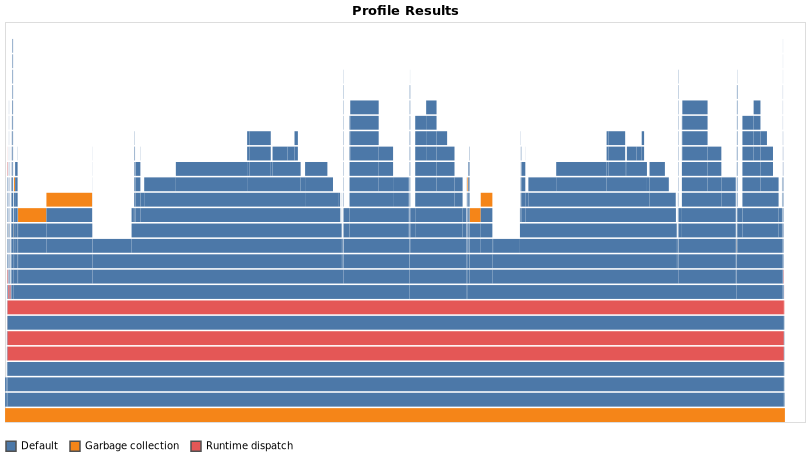

In [35]:
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in")
Profile.clear()
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in2")
ProfileVega.view()

In [36]:
using Printf

######################################################################################################
### The key observations here are the following.  The small obervations are here:
### a) The only way we can reach the target planet in 1 step is if a teleporter is equidistant from
###    the starter planet and the current planet.
### b) If we only have one teleporter and we can't reach the planet in one hop, then we can't reach
###    the planet in infinite hops, because we are stuck on the surface of the L1-sphere around
###    the only teleporter, and the planet isn't on the surface of that sphere.
### c) If we can't reach the planet in one hop, the set of possible positions is the union of L1-spheres
###    each of which is centered around a teleporter.  Note these L1-spheres have a radius of the
###    distance of the starting planet to the teleporter.  Furthermore, since the starting planet
###    is in EACH of these spheres, the entire network is CONNECTED.
### d) Now, consider a second hop using teleporter i.  We consider the CONNECTED set of possible
###    starting positions before this 2nd hop, and we realize that this connected set has a minimum
###    distance from teleporter i and a maximum distance from teleporter i.  Since that graph is
###    connected and since the distance function is continuous, it is possible to hop to any distance
###    from teleporter i between these two extreme.  Thus, the set of points where I can get using
###    teleporter i is the space between the surfaces of 2 concentric L-1 spheres centered at teleporter
###    i.
### e) This sets up a sort of dynamic programming approach.  We can calculate the next set of inner-outer
###    radii based on the previous set.  We notice that the outer radii will all increase at each step, and
###    the inner radii will decrease, so we will eventually hit the target planet.
###
###    --- Outer radii can be calculated as Ui = max_j{U_j + D_i,j}
###    --- Inner radii can be calculated as Li = min_J{ L_j > D_j ? L_j - D_j : U_j < D_j ? D_j - U_j : 0}
### f) The worst case here is when U_i == U_j and D_i,j = 1.  Then U_i and U_j will grow by 1 each step
###    so it will take 2000 steps to get from one end of the space to the other, so this is O(N^2*M)
###
### Now for the observations we need for the large.  In short, the biggest problem is that "M" factor.
### Note I didn't come up with most of this -- this is a summary of the given solution.
### g) Let's assume that we check for a 1 step solution beforehand.  Thus, we can assume we need to
###    take at least two steps.
### h) Now lets assume we have two teleporters, where one (say teleporter "u") is closer to the
###    starting planet (P), and one (say teleporter "v') is closer to the target planet (Q).  We claim
###    that when this is the case, we can always make it to the target planet in exactly 2 moves
###    by first using teleporter v and then using teleporter u.
###    --- To see this, we draw the L1-sphere around v that includes P.  This is where we can reach
###        on our first jump.
###    --- We also draw the L1 sphere around u that includes Q.  This represents the set of points from
###        which we can reach get to Q on the next jump.
###    --- We observe these two spheres intersect (technicals of the distance arguments omitted),
###        so there is an intermediate point we can use for the first hop.
### i) The previous observations suggests that there is a symmetry/reversability to the problem.  So we can
###    swap P and Q as needed such that all of the teleporters are closest to P.
### j) As per our discussion above in the short, U_i increases with steps, and L_i decreases with steps,
###    so after taking care of cases in (g) and (h) and perhaps switching the role so P/Q in (i), we
###    can assume that we are never limited by L_i (as Q isn't in the initial L_is, and the L_is shrink).
###    Thus, we only really have to worry about the U_is.
### k) Now we consider how the Ui terms grow.  The key observation is that if I start a path at i with Ui
###    and take several hops and end  at j, the "new Uj" is just the original Ui + the sum of the distances
###    of the hops I took.
### l) While we can't easily make an efficient dp for the "max possible" Ui, we can make a DP that calculates
###    the "longest path" from i to j in N hops.  The recursion that works is as follows
###    D[i,j,2^k] = max_x{D[i,x,2^(k-1)]+D[x,j,2^(k-1)]}.  We of course store the exponents (or 1+exponent
###    in the case of julia) as the 3rd index, but the recursion lets us get a set max distances for
###    binary hops in log(M)*N^3 time.
### m) After this, we just do a binary search on the number of hops which are needed
######################################################################################################

function main(infn="")
    infile = (infn != "") ? open(infn,"r") : length(ARGS) > 0 ? open(ARGS[1],"r") : stdin
    tt = parse(Int64,readline(infile))
    for qq in 1:tt
        print("Case #$qq: ")
        N = parse(Int64,rstrip(readline(infile)))
        Xs,Ys,Zs = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        Xf,Yf,Zf = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        X,Y,Z = fill(0,N),fill(0,N),fill(0,N)
        for i in 1:N
            X[i],Y[i],Z[i] = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        end

        Darr = fill(0,N,N)
        Ds = fill(0,N)
        Df = fill(0,N)
        for i in 1:N
            for j in i+1:N
                Darr[i,j] = Darr[j,i] = abs(X[j]-X[i]) + abs(Y[j]-Y[i]) + abs(Z[j]-Z[i])
            end
            Ds[i] = abs(Xs-X[i]) + abs(Ys-Y[i]) + abs(Zs-Z[i])
            Df[i] = abs(Xf-X[i]) + abs(Yf-Y[i]) + abs(Zf-Z[i])
        end

        ## Do the first
        first = false
        closerToF = false
        closerToS = false
        for i in 1:N
            if Ds[i] == Df[i]; first=true; break;
            elseif Ds[i] < Df[i]; closerToS=true;
            else;                 closerToF=true;
            end 
        end
        if first; print("1\n"); continue; end
        if N==1; print("IMPOSSIBLE\n"); continue; end 
        if closerToF && closerToS; print("2\n"); continue; end
        if closerToF; (Ds,Df) = (Df,Ds); end

        ## Build the longest distance matrix
        ## There will be some overflow, but we can walk our way up
        ## to what we need and then walk our way back down.
        ## the overflow will only happen

        Dtarg = repeat(Df',N,1) .- repeat(Ds,1,N)
        D = Vector{Array{Int128,2}}()
        D1 = Int128.(Darr)
        push!(D,D1)

        k = 1
        Dtry = fill(zero(Int128),N,N)
        while !any(D[end] .>= Dtarg)
            k += 1
            Dnew = fill(zero(Int128),N,N)
            for x in 1:N
                #Dtry .= repeat(D[end][:,x],1,N) .+ repeat(D[end][x,:]',N,1)
                Dtry .= [D[end][i,x]+D[end][x,j] for i in 1:N, j in 1:N]
                Dnew .= max.(Dnew,Dtry)
            end
            push!(D,Dnew)
        end

        if k==1; print("2\n"); continue; end
        if k==2; print("3\n"); continue; end
        Dub = copy(D[end])
        Dlb = copy(D[end-1])
        Dtest = fill(zero(Int128),N,N)
        ub = 2^(k-1)
        lb = 2^(k-2)
        for xidx in k-2:-1:1
            m = (ub+lb) ÷ 2
            fill!(Dtest,zero(Int128))
            for x in 1:N
                #Dtry .= repeat(Dlb[:,x],1,N) .+ repeat(D[xidx][x,:]',N,1)
                Dtry .= [Dlb[i,x]+D[xidx][x,j] for i in 1:N, j in 1:N]
                Dtest .= max.(Dtry,Dtest)
            end
            if any(Dtest .≥ Dtarg)
                Dub .= Dtest
                ub = m
            else
                Dlb .= Dtest
                lb = m
            end
        end
        print("$(ub+1)\n")
    end
end

main (generic function with 2 methods)

Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #4: 2190
Case #5: 57
Case #6: 14
Case #7: 2061
Case #8: 15
Case #9: 12
Case #10: 74
Case #11: 84
Case #12: 60
Case #13: 110
Case #14: 5
Case #15: 2
Case #16: 95
Case #17: 27
Case #18: 6
Case #19: 39
Case #20: 2
Case #21: 9
Case #22: 150
Case #23: 5997
Case #24: 15
Case #25: 60
Case #26: 47
Case #27: 193
Case #28: 2
Case #29: 187
Case #30: 2632
Case #31: 19
Case #32: 2318
Case #33: 2297
Case #34: 25
Case #35: 222
Case #36: 2105
Case #37: 18
Case #38: 40
Case #39: 1883
Case #40: 10
Case #41: 6
Case #42: 50
Case #46: 105
Case #47: 10
Case #48: 5997
Case #49: 31
Case #50: 5
Case #51: 1997
Case #52: 89
Case #53: 1999
Case #54: 34
Case #55: 33
Case #56: 23
Case #57: 2734
Case #58: 19
Case #59: 84
Case #60: 44
Case #61: 38
Case #62: 29
Case #63: 29
Case #64: 58
Case #65: 21
Case #66: 33
Case #67: 16
Case #68: 7
Case #69: 47
Case #70: 133
Case #71: 21
Case #72: 39
Case #73: 16
Case #74: 77
Case #75: 2001
C

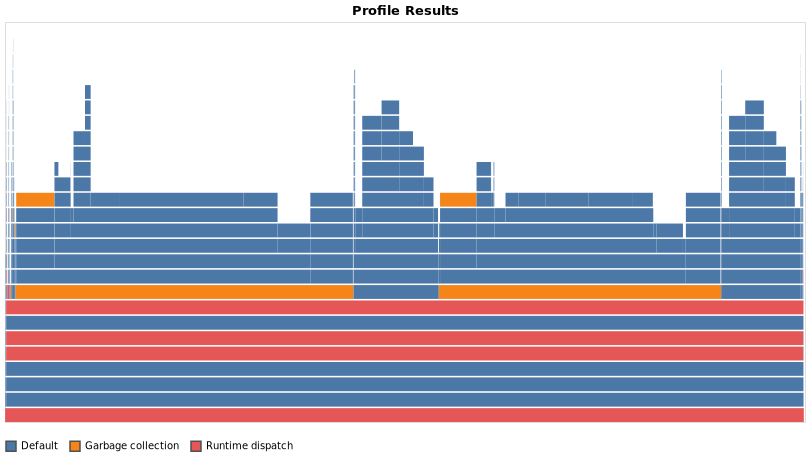

In [37]:
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in")
Profile.clear()
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in2")
ProfileVega.view()

In [38]:
c = zeros(Int128,4,4)

4×4 Array{Int128,2}:
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0

In [39]:
c .= [1 2 3 4] .+ [1;2;3;4]

4×4 Array{Int128,2}:
 2  3  4  5
 3  4  5  6
 4  5  6  7
 5  6  7  8

In [40]:
using Printf

######################################################################################################
### The key observations here are the following.  The small obervations are here:
### a) The only way we can reach the target planet in 1 step is if a teleporter is equidistant from
###    the starter planet and the current planet.
### b) If we only have one teleporter and we can't reach the planet in one hop, then we can't reach
###    the planet in infinite hops, because we are stuck on the surface of the L1-sphere around
###    the only teleporter, and the planet isn't on the surface of that sphere.
### c) If we can't reach the planet in one hop, the set of possible positions is the union of L1-spheres
###    each of which is centered around a teleporter.  Note these L1-spheres have a radius of the
###    distance of the starting planet to the teleporter.  Furthermore, since the starting planet
###    is in EACH of these spheres, the entire network is CONNECTED.
### d) Now, consider a second hop using teleporter i.  We consider the CONNECTED set of possible
###    starting positions before this 2nd hop, and we realize that this connected set has a minimum
###    distance from teleporter i and a maximum distance from teleporter i.  Since that graph is
###    connected and since the distance function is continuous, it is possible to hop to any distance
###    from teleporter i between these two extreme.  Thus, the set of points where I can get using
###    teleporter i is the space between the surfaces of 2 concentric L-1 spheres centered at teleporter
###    i.
### e) This sets up a sort of dynamic programming approach.  We can calculate the next set of inner-outer
###    radii based on the previous set.  We notice that the outer radii will all increase at each step, and
###    the inner radii will decrease, so we will eventually hit the target planet.
###
###    --- Outer radii can be calculated as Ui = max_j{U_j + D_i,j}
###    --- Inner radii can be calculated as Li = min_J{ L_j > D_j ? L_j - D_j : U_j < D_j ? D_j - U_j : 0}
### f) The worst case here is when U_i == U_j and D_i,j = 1.  Then U_i and U_j will grow by 1 each step
###    so it will take 2000 steps to get from one end of the space to the other, so this is O(N^2*M)
###
### Now for the observations we need for the large.  In short, the biggest problem is that "M" factor.
### Note I didn't come up with most of this -- this is a summary of the given solution.
### g) Let's assume that we check for a 1 step solution beforehand.  Thus, we can assume we need to
###    take at least two steps.
### h) Now lets assume we have two teleporters, where one (say teleporter "u") is closer to the
###    starting planet (P), and one (say teleporter "v') is closer to the target planet (Q).  We claim
###    that when this is the case, we can always make it to the target planet in exactly 2 moves
###    by first using teleporter v and then using teleporter u.
###    --- To see this, we draw the L1-sphere around v that includes P.  This is where we can reach
###        on our first jump.
###    --- We also draw the L1 sphere around u that includes Q.  This represents the set of points from
###        which we can reach get to Q on the next jump.
###    --- We observe these two spheres intersect (technicals of the distance arguments omitted),
###        so there is an intermediate point we can use for the first hop.
### i) The previous observations suggests that there is a symmetry/reversability to the problem.  So we can
###    swap P and Q as needed such that all of the teleporters are closest to P.
### j) As per our discussion above in the short, U_i increases with steps, and L_i decreases with steps,
###    so after taking care of cases in (g) and (h) and perhaps switching the role so P/Q in (i), we
###    can assume that we are never limited by L_i (as Q isn't in the initial L_is, and the L_is shrink).
###    Thus, we only really have to worry about the U_is.
### k) Now we consider how the Ui terms grow.  The key observation is that if I start a path at i with Ui
###    and take several hops and end  at j, the "new Uj" is just the original Ui + the sum of the distances
###    of the hops I took.
### l) While we can't easily make an efficient dp for the "max possible" Ui, we can make a DP that calculates
###    the "longest path" from i to j in N hops.  The recursion that works is as follows
###    D[i,j,2^k] = max_x{D[i,x,2^(k-1)]+D[x,j,2^(k-1)]}.  We of course store the exponents (or 1+exponent
###    in the case of julia) as the 3rd index, but the recursion lets us get a set max distances for
###    binary hops in log(M)*N^3 time.
### m) After this, we just do a binary search on the number of hops which are needed
######################################################################################################

function main(infn="")
    infile = (infn != "") ? open(infn,"r") : length(ARGS) > 0 ? open(ARGS[1],"r") : stdin
    tt = parse(Int64,readline(infile))
    for qq in 1:tt
        print("Case #$qq: ")
        N = parse(Int64,rstrip(readline(infile)))
        Xs,Ys,Zs = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        Xf,Yf,Zf = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        X,Y,Z = fill(0,N),fill(0,N),fill(0,N)
        for i in 1:N
            X[i],Y[i],Z[i] = [parse(Int64,x) for x in split(rstrip(readline(infile)))]
        end

        Darr = fill(0,N,N)
        Ds = fill(0,N)
        Df = fill(0,N)
        for i in 1:N
            for j in i+1:N
                Darr[i,j] = Darr[j,i] = abs(X[j]-X[i]) + abs(Y[j]-Y[i]) + abs(Z[j]-Z[i])
            end
            Ds[i] = abs(Xs-X[i]) + abs(Ys-Y[i]) + abs(Zs-Z[i])
            Df[i] = abs(Xf-X[i]) + abs(Yf-Y[i]) + abs(Zf-Z[i])
        end

        ## Do the first
        first = false
        closerToF = false
        closerToS = false
        for i in 1:N
            if Ds[i] == Df[i]; first=true; break;
            elseif Ds[i] < Df[i]; closerToS=true;
            else;                 closerToF=true;
            end 
        end
        if first; print("1\n"); continue; end
        if N==1; print("IMPOSSIBLE\n"); continue; end 
        if closerToF && closerToS; print("2\n"); continue; end
        if closerToF; (Ds,Df) = (Df,Ds); end

        ## Build the longest distance matrix
        ## There will be some overflow, but we can walk our way up
        ## to what we need and then walk our way back down.
        ## the overflow will only happen

        Dtarg = repeat(Df',N,1) .- repeat(Ds,1,N)
        D = Vector{Array{Int128,2}}()
        D1 = Int128.(Darr)
        push!(D,D1)

        k = 1
        Dtry = fill(zero(Int128),N,N)
        while !any(D[end] .>= Dtarg)
            k += 1
            Dnew = fill(zero(Int128),N,N)
            for x in 1:N
                Dnew .= max.(Dnew,D[end][:,x] .+ D[end][x,:]')
            end
            push!(D,Dnew)
        end

        if k==1; print("2\n"); continue; end
        if k==2; print("3\n"); continue; end
        Dub = copy(D[end])
        Dlb = copy(D[end-1])
        Dtest = fill(zero(Int128),N,N)
        ub = 2^(k-1)
        lb = 2^(k-2)
        for xidx in k-2:-1:1
            m = (ub+lb) ÷ 2
            fill!(Dtest,zero(Int128))
            for x in 1:N
                Dtest .= max.(Dtest,Dlb[:,x] .+ D[xidx][x,:]')
            end
            if any(Dtest .≥ Dtarg)
                Dub .= Dtest
                ub = m
            else
                Dlb .= Dtest
                lb = m
            end
        end
        print("$(ub+1)\n")
    end
end

main (generic function with 2 methods)

Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #1: IMPOSSIBLE
Case #2: 3
Case #3: 2
Case #4: 2190
Case #5: 57
Case #6: 14
Case #7: 2061
Case #8: 15
Case #9: 12
Case #10: 74
Case #11: 84
Case #12: 60
Case #13: 110
Case #14: 5
Case #15: 2
Case #16: 95
Case #17: 27
Case #18: 6
Case #19: 39
Case #20: 2
Case #21: 9
Case #22: 150
Case #23: 5997
Case #24: 15
Case #25: 60
Case #26: 47
Case #27: 193
Case #28: 2
Case #29: 187
Case #30: 2632
Case #31: 19
Case #32: 2318
Case #33: 2297
Case #34: 25
Case #35: 222
Case #36: 2105
Case #37: 18
Case #38: 40
Case #39: 1883
Case #40: 10
Case #41: 6
Case #42: 50
Case #43: 2334
Case #44: 30
Case #45: 139
Case #46: 105
Case #47: 10
Case #48: 5997
Case #49: 31
Case #50: 5
Case #51: 1997
Case #52: 89
Case #53: 1999
Case #54: 34
Case #55: 33
Case #56: 23
Case #57: 2734
Case #58: 19
Case #59: 84
Case #60: 44
Case #61: 38
Case #62: 29
Case #63: 29
Case #64: 58
Case #65: 21
Case #66: 33
Case #67: 16
Case #68: 7
Case #69: 47
Case #70: 133
Case #71: 21
Case #72: 39


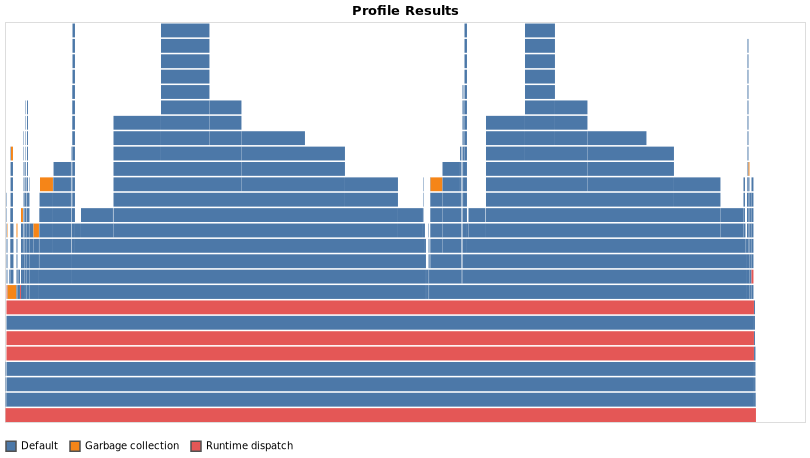

In [41]:
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in")
Profile.clear()
@profile main("/home/debr/codejams/julia/work/2017/WF/F.in2")
ProfileVega.view()

In [42]:
1+1

2